# Tutorial 5: Using the LDTk limb darkening model

The `TSModel` transmission spectroscopy transit model in ExoIris is based on PyTransit's `RRModel` and includes its ability to model stellar limb darkening using an arbitrary rotationally symmetric function. The LDTk limb darkening model (`exoiris.LDTkLD`) takes advantage of this and models stellar limb darkening using theoretical PHOENIX limb darkening profiles directly instead of representing it as simple analytical functions. 

for all the passbands parameterised by three stellar parameters: the effective temperature, log g, and metallicity.




The LDTk limb darkening is parameterised by ($T_\mathrm{Eff}$, $\log g$, $z$) model calculates the limb darkening profiles automatically for all passbands defined by a set of filters for a set of stellar parameters. This is very useful for transmission spectroscopy since the number of limb darkening parameters stays constant (three) no matter how many passbands are modelled simultaneously. 

**Author:** Hannu Parviainen <br>
**Edited:** 7 November 2024

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [3]:
from multiprocessing import Pool
from xarray import load_dataset
from scipy.interpolate import splev, splrep
from numpy import array, geomspace, linspace
from matplotlib.pyplot import subplots, setp

from exoiris import ExoIris, TSData, LDTkLD
from ldtk import BoxcarFilter

## Data preparation

In [4]:
def read_data(fname, name=""):
    with load_dataset(fname) as ds:
        return TSData(time=ds.time.values, wavelength=ds.wavelength.values, fluxes=ds.flux.values, errors=ds.error.values, name=name)

d1 = read_data('data/nirHiss_order_1.h5', "WASP-39b JWST NIRISS Order 1")
d1.remove_outliers()
d1.mask_transit(t0=2459783.5015, p=4.0552842, t14=0.13)
d1.normalize_to_poly()

d2 = read_data('data/nirHiss_order_2.h5', "WASP-39b JWST NIRISS Order 2")
d2.remove_outliers()
d2.crop_wavelength(d2.bbox_wl[0], 1.0)
d2.mask_transit(ephemeris=d1.ephemeris)
d2.normalize_to_poly()

TSData Name:'WASP-39b JWST NIRISS Order 2' [0.57 - 1.00] nwl=957 npt=518

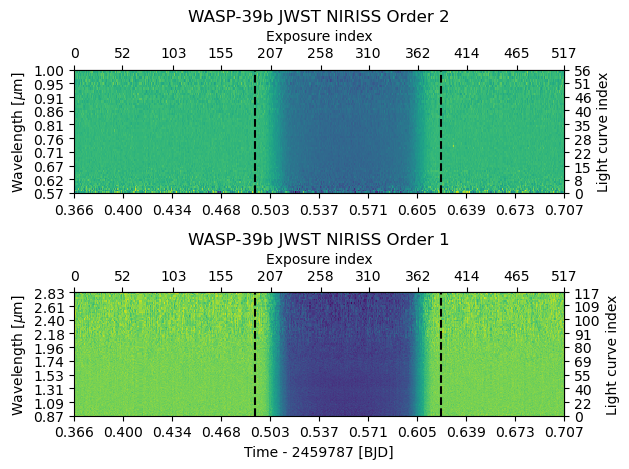

In [5]:
db = d2.bin_wavelength(r = 100) + d1.bin_wavelength(r = 100)
fig = db.plot()
fig.tight_layout()

## Setup the LDTk limb darkening model

The way `LDTkLD` works is familiar to anyone who has used `LDTk` before. You initialise the model by giving it the stellar effective temperature, surface gravity, and metallicity estimates as (mean, $1\sigma$ uncertainty) tuples and a set of filters. You can also optionally tell the model which theoretical stellar spectrum dataset it should use (`vis`, `vis-lowres`, `visir`, or `visir-lowres`). For JWST transmission spectroscopy, one should choose either `visir`, or `visir-lowres`.

In [49]:
ldm = LDTkLD(db, teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), dataset='visir-lowres')

In [50]:
ts = ExoIris('05a_ldtk_limb_darkening', ldmodel=ldm, data=db, nk=50, nldc=10, nthreads=1)

Now, when we look at the model parameterisation, we notice the limb darkening is parameterised only by the three stellar parameters `teff`, `logg`, and `metal`. The priors are taken automatically from `LDTkLD`.

In [52]:
ts.ps[:10]

[  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   1 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   2 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   4 |G| secw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   6 |G| teff           N(μ = 5327.0, σ = 139.0)                 [    0.00 ..      inf],
   7 |G| logg           N(μ = 4.38, σ = 0.09)                    [    0.00 ..      inf],
   8 |G| metal          N(μ = -0.01, σ = 0.1)                    [    -inf ..      inf],
   9 |G| k_00.57318     U(a = 0.02, b = 0.2)                     [    0.00 ..      inf]]

In [22]:
ts.set_prior('tc', 'NP', 2459694.286, 0.003)
ts.set_prior('p', 'NP', 4.05487, 1e-5)

In [23]:
ts.set_radius_ratio_prior('UP', 0.14, 0.15)

### Customise the radius ratio knot locations

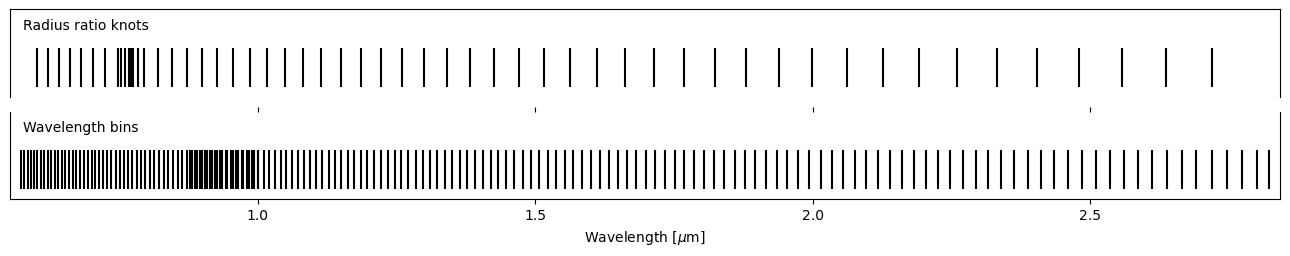

In [24]:
ts.set_radius_ratio_knots(geomspace(ts.data[0].wavelength[5], ts.data[1].wavelength[-5], 50))
ts.add_radius_ratio_knots(linspace(0.768-0.015, 0.768+0.015, 5))
ts.set_radius_ratio_prior('UP', 0.14, 0.15)
ts.plot_setup();

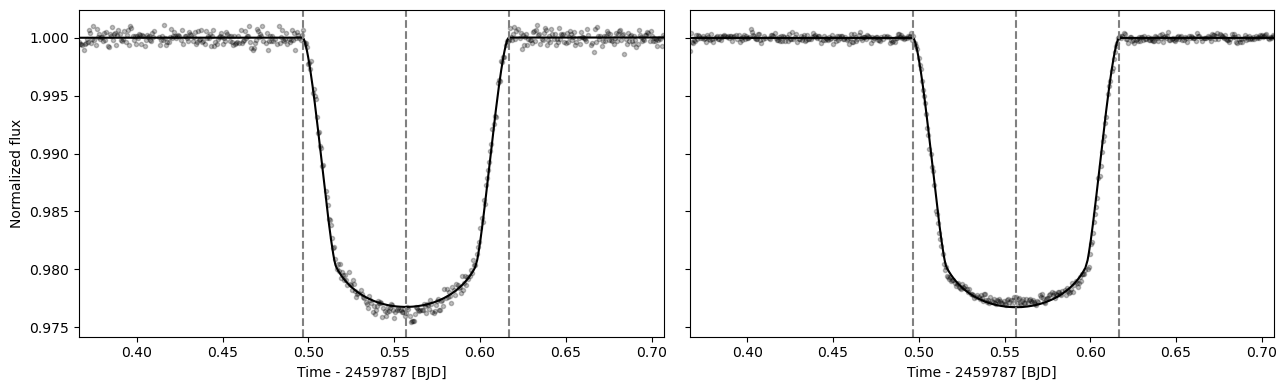

In [25]:
ts.fit_white()
fig = ts.plot_white(figsize=(13,4))
fig.tight_layout()

In [26]:
ts.save(overwrite=True)

### Set up multiprocessing

Now we're almost ready for fitting and MCMC sampling, but since we're using multiprocessing to parallelise the process, we first need to take some extra steps to make sure everything works the way it's supposed to.

First, we need to define a log-posterior function that calls the `ExoIris` log-posterior method. This must be done so that Python can pickle the method for parallelisation (if you know a better way, please let me know). Next, we also create a multiprocessing pool that will be used by the global optimiser and the MCMC sampler.

In [29]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

### Fit the transmission spectrum

Global optimisation:   0%|          | 0/2500 [00:00<?, ?it/s]

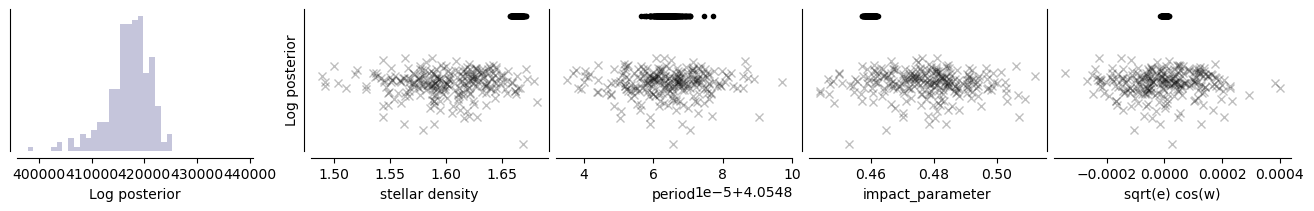

In [37]:
ts.fit(niter=2500, npop=250, pool=pool, lnpost=lnpostf)

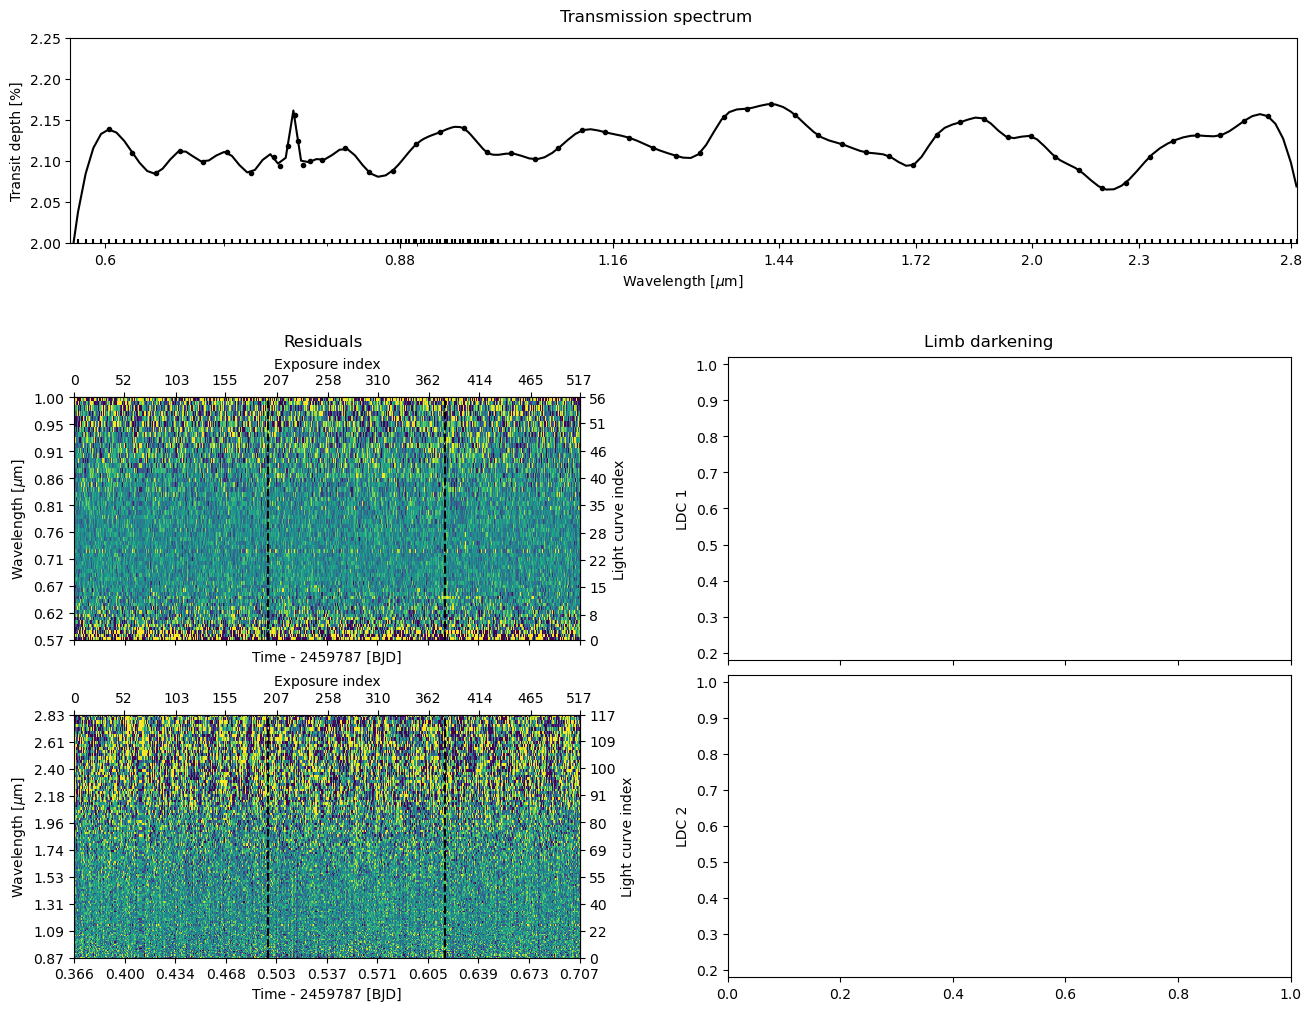

In [38]:
ts.plot_fit(result='fit', figsize=(13,10), height_ratios=(0.3, 0.7),
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]));

We can immediately see from the residual plot that the current best-fit solution is bad. This is something we could have guessed already by looking at the log posterior distribution in the optimiser plot that shows a spread of tens of thousands. Let's continue the fitting for another 25 iterations. Each successive `ExoIris.fit` call continues optimisation from the solution of the previous call, and it also plots the old and new posterior and parameter populations at the end of the fit to visualise how the population is changing.

So, it is clear at this stage that running the optimiser for 25 iterations is not doing much. Let's continue the optimisation for 5000 iterations and see if this does the trick. This should take 2-3 min (or less if you initialise the pool with more processes) and the optimisation should finish before it reaches 5000 iterations (the progress bar turns red).

Global optimisation:   0%|          | 0/5000 [00:00<?, ?it/s]

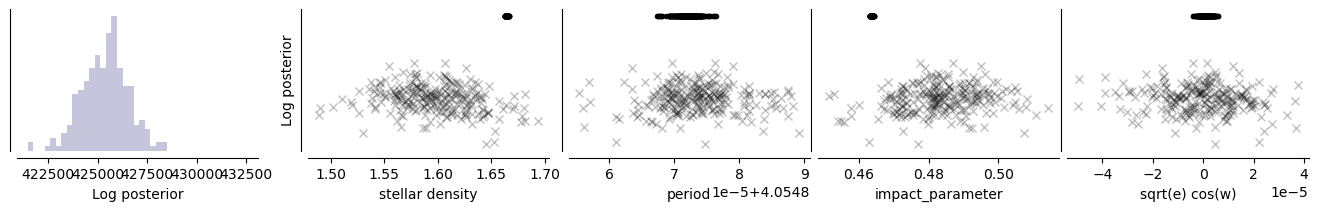

In [30]:
ts.fit(niter=5000, npop=250, pool=pool, lnpost=lnpostf)

Let's plot everything once again. This time, the residuals look good (there's no trace of a transit signal there), the transmission spectrum looks something else than just noise, and the limb darkening parameters also look good, so we're ready to move to the final step: the MCMC sampling.

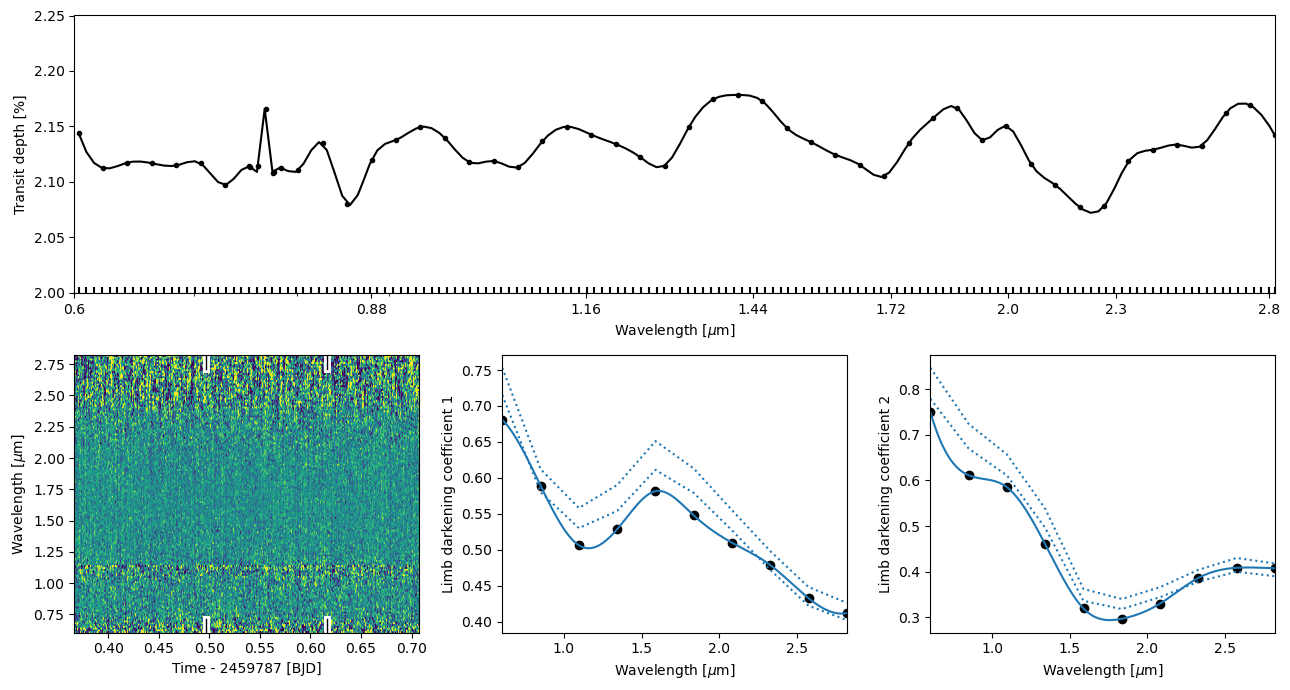

In [32]:
ts.plot_fit(result='fit', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

### Save the optimisation results

In [39]:
ts.save(overwrite=True)

### MCMC sampling

Next comes the final part, obtaining a posterior sample using Markov Chain Monte Carlo (MCMC) sampling. This is done using the `ExoIris.sample` method, that starts with the parameter vector population from the global optimisation. 

As a first step, let's still inflate the limb darkening parameter prior widths by ten to make sure we're not constraining them too much in the sampling phase. So, now we set `uncertainty_multiplier=100` instead of `uncertainty_multiplier=10` that we used in fitting.

In [40]:
ts.sample(1000, thin=100, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
df = ts._tsa.posterior_samples()

In [47]:
import ldtk

In [48]:
ldtk.__version__

Version('1.8.4')

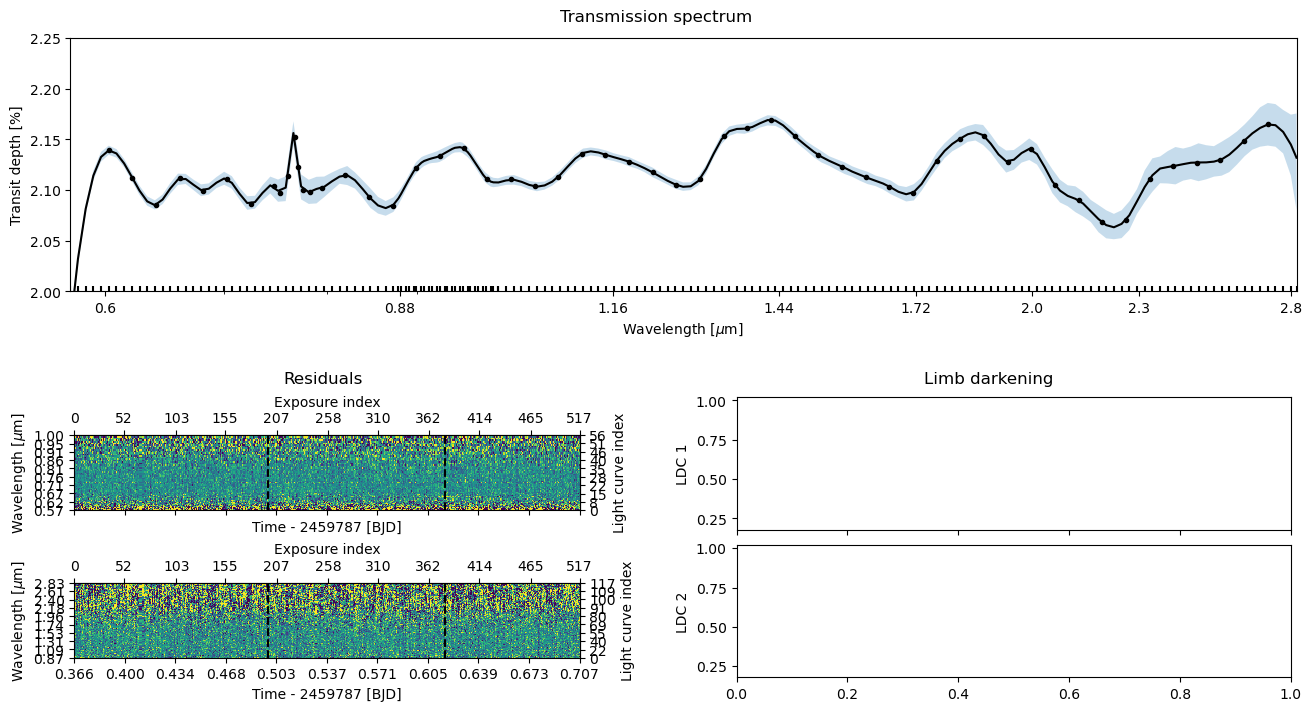

In [43]:
ts.plot_fit(result='mcmc', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]));

### Save the results and export the transmission spectrum

Congratulations, you now have a low-resolution transmission spectrum for your observations! Let's save the model one more time to also store the posterior samples inside the fits file.

In [44]:
ts.save(overwrite=True)

In [46]:
ts.transmission_spectrum

wavelength,radius_ratio,radius_ratio_e,area_ratio,area_ratio_e
um,,,,
float64,float64,float64,float64,float64
0.5731806007740325,0.14015972198590915,0.0002946211952941102,0.019644747667203616,8.260477409168684e-05
0.5789412098270379,0.14255500096953785,0.0001970778993912647,0.02032192830145446,5.6193077320264214e-05
0.5847597144484151,0.1442734705162264,0.00016348873700431724,0.02081483429480218,4.717799283285726e-05
0.5906366965031731,0.14540652332722578,0.00016201349387189487,0.021143057026111134,4.712005749875868e-05
0.59657274370421,0.14604012229579705,0.0001621752253652372,0.021327717320235594,4.737224591468161e-05
0.6025684496710865,0.14626237897238517,0.00015550270570965281,0.021392683502665752,4.5490326640701425e-05
0.6086244139893888,0.14615818417316961,0.0001463822205448086,0.021362214800803664,4.2790612092112884e-05
0.6147412422706893,0.14582020417274466,0.0001430773724558657,0.021263531944991892,4.1729795817659045e-05


---

<center>&copy;2024 Hannu Parviainen</center>